In [1]:
from imports import *
import AudioTransforms
from DeReverbDataset import *
from utils import *
%matplotlib inline
from fastprogress import master_bar, progress_bar

In [2]:
plt.style.use('Solarize_Light2')  # Just changes plotting theme, comment out if annoying
matplotlib.rcParams['figure.figsize'] = [10, 8]

Hyperparams for Data

In [3]:
speech_sr = 16000
frame_len = 4096
bs = 32
data_path = Path("/scratch/data")

## Create Transforms
`rev_tfms` is the transforms that will only be applied to the reverberant audio (input)  
`clean_tfms` is the transforms that will also be applied to the clean audio signal (target)

Note: if sample rate of files does not match sample rate passed, transforms will resample all audio files they need. This can take a *WHILE* if the conflicting sample rates are not integer multiples.

In [4]:
rev_tfms = transforms.Compose([AudioTransforms.Reverb(data_path/'impulse-responses', speech_sr)])#,
                               #AudioTransforms.Noise(data_path/'noise', None, -4, 2)])
#clean_tfms = transforms.Compose([AudioTransforms.RandomCrop(frame_len)])
crop_load = AudioTransforms.LoadCrop(length=frame_len)

## Create a Dataset

In [5]:
dataset = DeReverbDataset(data_path, rev_tfms=rev_tfms, crop_load=crop_load)

train_size = int(0.8 * len(dataset))
valid_size = len(dataset) - train_size
train_ds, valid_ds = torch.utils.data.random_split(dataset, [train_size, valid_size])

## Create a Dataloader

In [6]:
train_dl = DataLoader(train_ds, batch_size=bs, shuffle=True, num_workers=12, pin_memory=True)
valid_dl = DataLoader(valid_ds, batch_size=bs, shuffle=True, num_workers=12, pin_memory=True)

## Check out some data

In [ ]:
%%time
for batch in tqdm(train_dl):
    pass

In [8]:
batch_ex = next(iter(train_dl))

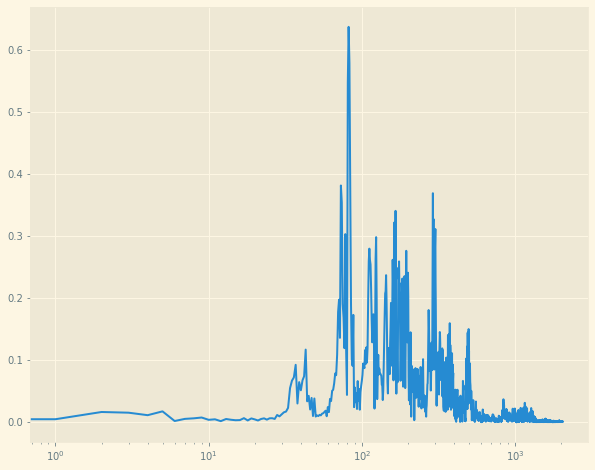

In [37]:
plt.plot(cabs(cbatch).T.numpy())
plt.xscale('log')

In [38]:
cbatch_hat = cbatch.irfft(1)

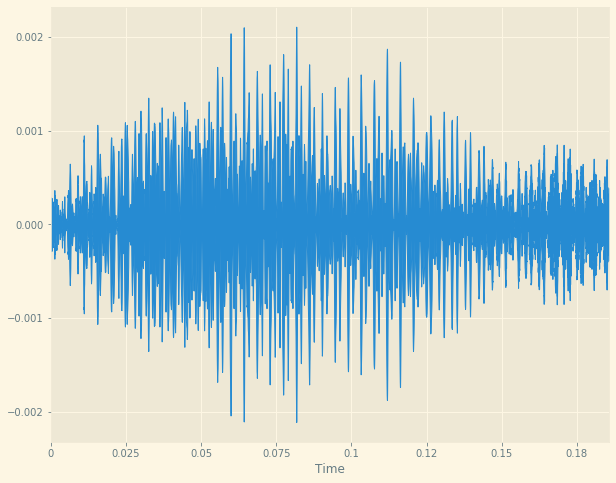

In [11]:
#plot_spec(batch_ex['reverbed'][0])
waveplot(batch_ex[0][0].squeeze().numpy())
Audio(batch_ex[0][0], rate=speech_sr)

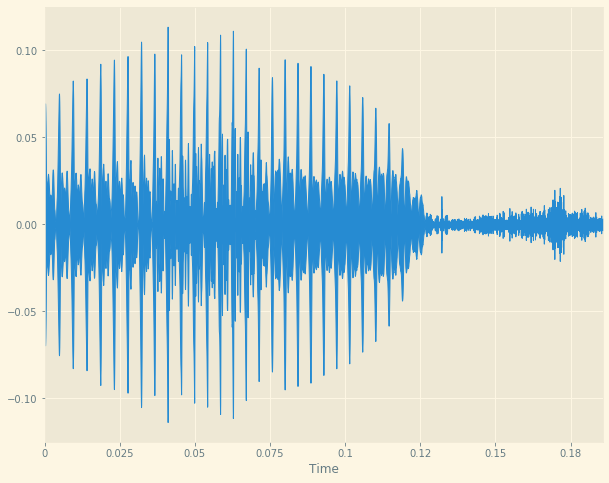

In [12]:
#plot_spec(batch_ex['clean'][0])
waveplot(batch_ex[1][0].squeeze().numpy())
Audio(batch_ex[1][0], rate=speech_sr)

## Segan network

Figure from Pandey-Wang paper

![unet](papers/images/unet-inspired.png)

Cola function ensures that ovelapping windows will sum to a constant.

In [13]:
def cola_window(win_size, hop_len, win_type=np.hamming):
    w = win_type(win_size)
    w = np.sqrt(w)
    K = np.sqrt(hop_len / sum(pow(w,2)))
    w = w * K
    return w

In [191]:
def polar_to_cart(x):
    amp = x[:,:,0].unsqueeze(-1)
    phase = x[:,:,1].unsqueeze(-1)
    return torch.cat((amp*torch.cos(phase), amp*torch.sin(phase)), dim=-1)

In [5]:
class ConvNet(nn.Module):
    def __init__(self, kernel_size):
        super(ConvNet, self).__init__()
        sizes = [(2048, 64), (1024, 64), (512, 64), (256, 128), (128, 128), (64, 128), (32, 256), (16,256), (8, 256)]
        self.sizes = sizes
        padding = kernel_size // 2
        self.input = nn.Conv1d(1, sizes[0][1], kernel_size, 1, padding)
        
        self.encoder = nn.Sequential(
            *[nn.Conv1d(sizes[i-1][1], sizes[i][1], kernel_size, 2, padding, dilation=1) for i in range(1, len(sizes))]
        )
        self.decoder = nn.Sequential(
            *[nn.ConvTranspose1d(2*sizes[-i+1][1], sizes[-i][1], kernel_size, 2, padding, 1, dilation=1) for i in range(2,len(sizes)+1)]
        )
        
        self.output = nn.ConvTranspose1d(sizes[0][1], 1, kernel_size, 1, padding)
        
    def forward(self, x):
        x = self.input(x)
        enc_outs = []
        for l in self.encoder:
            x = F.relu(l(x))
            enc_outs.append(x)
        for i,l in enumerate(self.decoder):
            x = F.relu(l(torch.cat((x, F.relu(enc_outs[-i-1])), 1)))
        x = torch.tanh(self.output(x))
        return x
    
    def reconstruct(self, x, hop_len=256):
        x = x.detach().cpu()
        size = self.sizes[0][0]
        window = torch.from_numpy(cola_window(size, hop_len)).float()
        output = torch.zeros(x.shape)
        for frame in range(x.shape[-1]//hop_len):
            try:
                f = x[:,hop_len*frame:hop_len*frame+size]
                amp,phase = fourier(f, len(f))
                amp = self.forward(amp.unsqueeze(0).cuda()).detach().cpu()
                f = cat(amp,phase, dim=-1)
                # fix here
                windowed = window.squeeze() * f.squeeze()
                output[:,hop_len*frame:hop_len*frame+size] += windowed
            except:
                pass
        return output

In [6]:
hop_len=256
frame = 0
size = 1024
x = speech_ex
f = x[:,hop_len*frame:hop_len*frame+size].unsqueeze(-1).unsqueeze(0)
amp,phase = fourier(f, size//2)

NameError: name 'speech_ex' is not defined

In [229]:
f.shape

torch.Size([1, 1, 1024, 1])

In [230]:
amp.shape

torch.Size([1, 1, 512, 1])

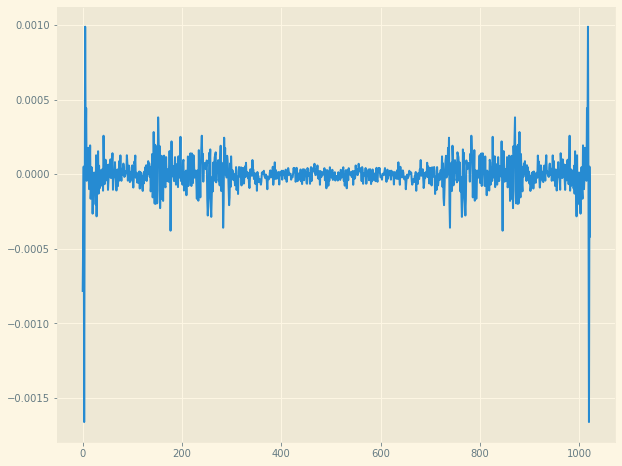

In [231]:
catted = polar_to_cart(torch.cat((amp.squeeze(0), phase.squeeze(0)), dim=-1))
tagain = catted.irfft(1)
plt.plot(tagain.T.numpy())

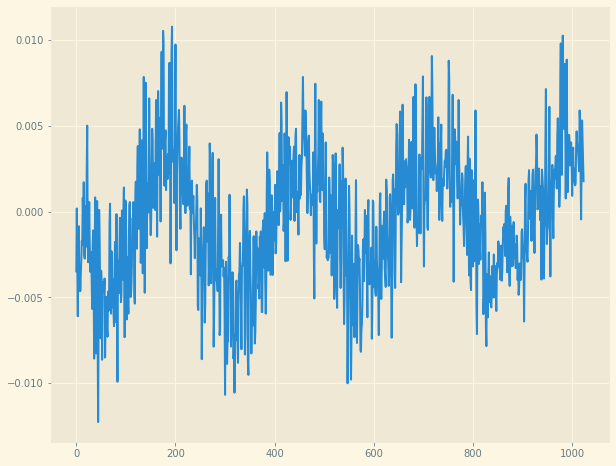

In [232]:
plt.plot(speech_ex.T.numpy()[:1024])

In [15]:
def fourier(x, frame_len):
    return taf.magphase(x.rfft(1)[:,:,:frame_len,:])

In [22]:
# Try to destroy any existing network on the GPU before creating new
try:
    del cnet
except:
    pass
cnet = ConvNet(kernel_size=7)
cnet.cuda()
critereon = nn.MSELoss()
optim = torch.optim.Adam(cnet.parameters(), lr=1e-3)

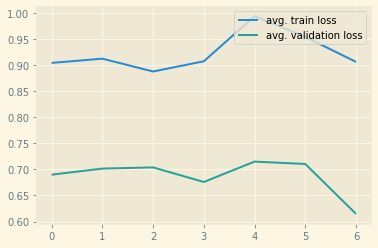

In [23]:
n_epochs = 7

mb = master_bar(range(n_epochs))
mb.names = ['avg. train loss', 'avg. validation loss']
train_losses = []
valid_losses = []
for epoch in mb:
    cnet.train()
    tl = 0
    for data in progress_bar(train_dl, parent=mb):

        # Index needed for some ridiculous reason because torch.rfft
        # has one extra element than it needs
        inputs = fourier(data[0].cuda(), frame_len//2)[0]
        targets = fourier(data[1].cuda(), frame_len//2)[0]
        
        optim.zero_grad()

        outputs = cnet.forward(inputs)
        loss = critereon(outputs, targets)
        loss.backward()
        optim.step()

        tl += loss.cpu().detach().numpy()
    train_losses.append(tl/train_size)
    
    cnet.eval()
    vl = 0
    with torch.no_grad():
        for data in progress_bar(valid_dl, parent=mb):
            inputs = fourier(data[0].cuda(), frame_len//2)[0]
            targets = fourier(data[1].cuda(), frame_len//2)[0]

            outputs = cnet.forward(inputs)
            loss = critereon(outputs, targets)

            vl += loss.cpu().detach().numpy()

        valid_losses.append(vl/valid_size)
        
    mb.update_graph([[range(len(train_losses)), train_losses], [range(len(valid_losses)), valid_losses]])
    #print(f'epoch {epoch} loss: {epoch_loss}')

In [28]:
ir_ex = ta.transforms.Resample(48000, 16000)(ta.load((data_path/'impulse-responses').ls()[2])[0])[0,:]

reverb = AudioTransforms.Reverb([(data_path/'impulse-responses').ls()[2]], speech_sr)
noise = AudioTransforms.Noise(data_path/'noise', None, -8, 2)

In [29]:
speech_ex, sr = ta.load(random.choice((data_path/'clean-speech').ls()))
reverbed = noise(speech_ex)

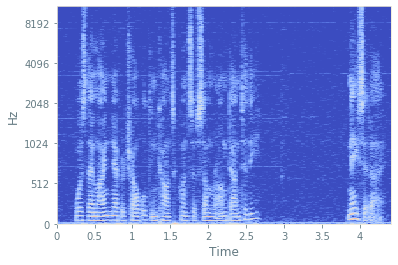

In [126]:
plot_spec(speech_ex.squeeze().numpy())
Audio(speech_ex.squeeze().numpy(), rate=sr)

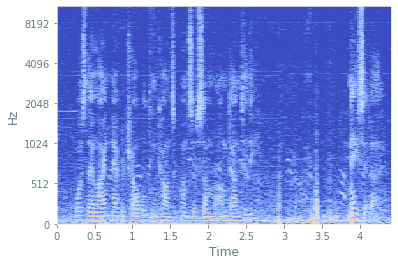

In [127]:
plot_spec(reverbed.squeeze().numpy())
Audio(reverbed, rate=sr)

In [128]:
cnet.eval()

reconstructed = cnet.reconstruct(reverbed).numpy()

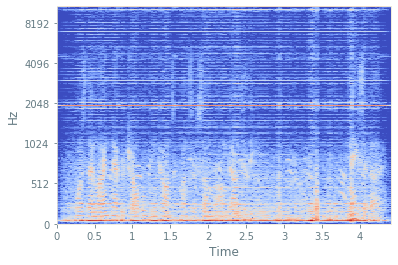

In [129]:
plot_spec(reconstructed.squeeze())
Audio(reconstructed, rate=sr)

## FCNN

In [42]:
# define network
class Net(nn.Module):

    def __init__(self, num_features, num_hidden, num_output):
        super(Net, self).__init__()  
        self.l1 = nn.Linear(num_features, num_hidden)
        self.act = nn.ReLU()
        self.l2 = nn.Linear(num_hidden, num_output)

    def forward(self, x):
        x = self.l1(x)
        x = self.act(x)
        x = self.l2(x)
        return x

In [43]:
try:
    del net
except:
    pass

speech_sr = 16000
net = Net(2048, 512, 2048)
net.cuda()

Net(
  (l1): Linear(in_features=2048, out_features=512, bias=True)
  (act): ReLU()
  (l2): Linear(in_features=512, out_features=2048, bias=True)
)

In [14]:
critereon = nn.MSELoss()
optim = torch.optim.Adam(net.parameters(), lr=1e-4)

NameError: name 'net' is not defined

In [ ]:
n_epochs = 100

mb = master_bar(range(n_epochs))
mb.names = ['train loss']
epoch_losses = []
for epoch in mb:
    for data in progress_bar(dl, parent=mb):

        epoch_loss = 0

        inputs = data['reverbed'].cuda()
        targets = data['clean'].cuda()

        outputs = net.forward(inputs)
        loss = critereon(outputs, targets)
        loss.backward()
        optim.step()
        optim.zero_grad()

        epoch_loss += loss.cpu().detach().numpy()
        
    epoch_losses.append(epoch_loss)
    mb.update_graph([[range(epoch+1), epoch_losses]])
    #print(f'epoch {epoch} loss: {epoch_loss}')

In [144]:
net.eval()
output = net.forward(next(iter(dl))['reverbed'].cuda())
output = output[0,:].squeeze().detach().cpu()

In [148]:
Audio(output, rate=16000)

## Ideas
1. CNN to encode frames to features
2. RNN which takes cnn frames and generates output
3. Pair with FC layer after RNN
4. Try adding a RNN to latent space to learn temporal context. Use output of rnn to reconstruct
5. Try MAE loss
6. Get working in Colab